# Xây dựng Pipeline cho ảnh đơn lẻ

Notebook này tạo một pipeline hoàn chỉnh để phân tích tư thế em bé từ một ảnh đơn lẻ:
1. Tải mô hình RandomForest đã huấn luyện và scaler
2. Tạo class Pipeline để xử lý ảnh
3. Hiển thị kết quả phân tích tư thế trên ảnh

In [1]:
# Import các thư viện cần thiết
import os
import sys
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Cấu hình matplotlib để hỗ trợ hiển thị tiếng Việt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
# Fix UTF-8 encoding cho Windows
plt.rcParams['axes.unicode_minus'] = False

# Đường dẫn gốc của dự án
ROOT_PATH = Path('d:/GiaoPhan_Workspace/sem_6/pbl5/baby_posture_analysis')
# Thêm đường dẫn vào sys.path để import các module tự định nghĩa
sys.path.append(str(ROOT_PATH))

# Import các module tự định nghĩa
from app.utils.image_helper import Image_Helper, Image_Rotation_Helper
from app.utils.keypoints_helper import KeypointsExtractorHelper

In [2]:
# Định nghĩa các keypoints quan trọng
IMPORTANT_KEYPOINTS= [
    "nose",
    "left_eye_inner",
    "left_eye",
    "left_eye_outer",
    "right_eye_inner",
    "right_eye",
    "right_eye_outer",
    "left_ear",
    "right_ear",
    "mouth_left",
    "mouth_right",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_wrist",
    "right_wrist",
    "left_pinky",
    "right_pinky",
    "left_index",
    "right_index",
    "left_thumb",
    "right_thumb",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_ankle",
    "right_ankle",
    "left_heel",
    "right_heel",
    "left_foot_index",
    "right_foot_index",
]

# Khởi tạo các đối tượng MediaPipe
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# Định nghĩa đường dẫn
MODEL_PATH = ROOT_PATH / 'app' / 'models'

# Map số sang tên lớp
CLASS_LABELS = {
    0: 'Nằm ngửa',
    1: 'Nằm nghiêng', 
    2: 'Nằm sấp'
}

In [3]:
class BabyPosturePipeline:
    """
    Pipeline hoàn chỉnh để phân tích tư thế em bé từ một ảnh đơn lẻ
    """
    
    def __init__(self, model_path, scaler_path):
        """
        Khởi tạo pipeline
        
        Args:
            model_path: Đường dẫn đến file mô hình
            scaler_path: Đường dẫn đến file scaler
        """
        # Load mô hình và scaler
        self.model = self._load_model(model_path)
        self.scaler = self._load_model(scaler_path)
        
        # Khởi tạo các đối tượng cần thiết cho xử lý ảnh
        self.mp_pose = mp_pose
        self.mp_drawing = mp_drawing
        self.mp_drawing_styles = mp_drawing_styles
        
        # Khởi tạo pose detector từ MediaPipe
        self.pose = self.mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=True,
            min_detection_confidence=0.5
        )
        
        # Khởi tạo các helper
        self.image_helper = Image_Helper()
        self.image_rotation_helper = Image_Rotation_Helper()
        self.keypoints_helper = KeypointsExtractorHelper(IMPORTANT_KEYPOINTS, mp_pose)
    
    def _load_model(self, file_path):
        """
        Load mô hình từ file
        
        Args:
            file_path: Đường dẫn đến file mô hình
            
        Returns:
            model: Mô hình đã được load
        """
        with open(file_path, 'rb') as file:
            model = pickle.load(file)
        return model
    
    def preprocess_image(self, image_path):
        """
        Tiền xử lý ảnh từ đường dẫn
        
        Args:
            image_path: Đường dẫn đến file ảnh
            
        Returns:
            image_rgb: Ảnh đã được tiền xử lý
            original_image: Ảnh gốc đã được đọc
        """
        # Đọc ảnh
        original_image = cv2.imread(str(image_path))
        
        # Kiểm tra xem ảnh có phải là ảnh grayscale không
        if len(original_image.shape) == 2 or original_image.shape[2] == 1:
            # Chuyển đổi grayscale sang RGB
            original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
        
        # Chuyển đổi ảnh sang định dạng vuông
        image_squared, new_size = self.image_helper.square_image(original_image)
        
        # Chuyển đổi ảnh sang RGB (MediaPipe yêu cầu RGB)
        image_rgb = cv2.cvtColor(image_squared, cv2.COLOR_BGR2RGB)
        
        return image_rgb, original_image
    
    def extract_keypoints(self, image):
        """
        Trích xuất keypoints từ ảnh
        
        Args:
            image: Ảnh cần trích xuất keypoints
            
        Returns:
            df_keypoints: DataFrame chứa các keypoints đã được trích xuất
            results: Kết quả trích xuất từ MediaPipe
        """
        # Xử lý ảnh với MediaPipe Pose
        results = self.pose.process(image)
        
        # Kiểm tra xem có phát hiện được pose không
        if not results.pose_landmarks:
            return None, None
        
        # Chuẩn hóa hướng của pose
        results.pose_landmarks = self.image_rotation_helper.rotate_image_baby(results.pose_landmarks)
        
        # Trích xuất và chuẩn hóa các keypoints sử dụng helper
        df_keypoints = self.keypoints_helper.process_keypoints(results.pose_landmarks.landmark)
        
        return df_keypoints, results
    
    def predict(self, df_keypoints):
        """
        Dự đoán tư thế từ keypoints
        
        Args:
            df_keypoints: DataFrame chứa các keypoints
            
        Returns:
            predicted_class: Lớp dự đoán
            probabilities: Xác suất cho mỗi lớp
        """
        # Chuẩn hóa dữ liệu
        X = self.scaler.transform(df_keypoints.values.reshape(1, -1))
        
        # Dự đoán
        predicted_class = self.model.predict(X)[0]
        probabilities = self.model.predict_proba(X)[0]
        
        return predicted_class, probabilities
    
    def visualize_result(self, image, results, predicted_class, probabilities):
        """
        Hiển thị kết quả trên ảnh
        
        Args:
            image: Ảnh gốc
            results: Kết quả từ MediaPipe
            predicted_class: Lớp dự đoán
            probabilities: Xác suất cho mỗi lớp
            
        Returns:
            annotated_image: Ảnh với kết quả phân tích
        """
        # Copy ảnh để vẽ trên đó
        annotated_image = image.copy()
        
        # Vẽ landmarks
        self.mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            self.mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=self.mp_drawing_styles.get_default_pose_landmarks_style())
        
        # Thêm thông tin về tư thế được dự đoán
        predicted_label = CLASS_LABELS[predicted_class]
        
        # Sử dụng PIL thay vì cv2 để hiển thị text tiếng Việt
        from PIL import Image, ImageDraw, ImageFont
        
        # Chuyển đổi ảnh từ numpy array sang PIL Image
        pil_image = Image.fromarray(annotated_image)
        draw = ImageDraw.Draw(pil_image)
        
        # Tìm font hỗ trợ Unicode
        try:
            # Font cho Windows với kích thước nhỏ hơn
            font_large = ImageFont.truetype("arial.ttf", 20)
            font_small = ImageFont.truetype("arial.ttf", 16)
        except IOError:
            try:
                # Font cho Linux với kích thước nhỏ hơn
                font_large = ImageFont.truetype("DejaVuSans.ttf", 20)
                font_small = ImageFont.truetype("DejaVuSans.ttf", 16)
            except IOError:
                # Fallback nếu không tìm thấy font
                font_large = ImageFont.load_default()
                font_small = ImageFont.load_default()
        
        # Vị trí văn bản - không còn nền trắng
        y_offset = 10
        
        # Thêm viền cho text để dễ đọc hơn trên nền ảnh bất kỳ
        shadow_offset = 1
        shadow_color = (0, 0, 0)  # Đen
        text_color = (255, 255, 255)  # Trắng
        
        # Thêm text thông tin kết quả với viền
        text = f"Tư thế: {predicted_label}"
        # Vẽ viền (shadow) bằng cách vẽ text ở các vị trí lệch nhau một chút
        for dx, dy in [(-shadow_offset, -shadow_offset), (shadow_offset, -shadow_offset),
                      (-shadow_offset, shadow_offset), (shadow_offset, shadow_offset)]:
            draw.text((10 + dx, y_offset + dy), text, font=font_large, fill=shadow_color)
        # Vẽ text chính
        draw.text((10, y_offset), text, font=font_large, fill=text_color)
        
        # Thêm thông tin về xác suất
        for i, (label, prob) in enumerate(zip(CLASS_LABELS.values(), probabilities)):
            confidence = f"{label}: {prob*100:.1f}%"
            y_pos = y_offset + 25 + i*20
            
            # Vẽ viền
            for dx, dy in [(-shadow_offset, -shadow_offset), (shadow_offset, -shadow_offset),
                          (-shadow_offset, shadow_offset), (shadow_offset, shadow_offset)]:
                draw.text((10 + dx, y_pos + dy), confidence, font=font_small, fill=shadow_color)
            # Vẽ text chính
            draw.text((10, y_pos), confidence, font=font_small, fill=text_color)
        
        # Chuyển đổi lại từ PIL Image sang numpy array
        annotated_image = np.array(pil_image)
        
        return annotated_image
    
    def process_image(self, image_path):
        """
        Xử lý ảnh và trả về kết quả phân tích tư thế
        
        Args:
            image_path: Đường dẫn đến file ảnh
            
        Returns:
            result_image: Ảnh với kết quả phân tích
            predicted_class: Lớp dự đoán
            probabilities: Xác suất cho mỗi lớp
        """
        try:
            # Tiền xử lý ảnh
            self.pose.close() 
            self.pose = self.mp_pose.Pose(
                static_image_mode=True,
                model_complexity=2,
                enable_segmentation=True,
                min_detection_confidence=0.5
            )
            image_rgb, original_image = self.preprocess_image(image_path)
            
            # Trích xuất keypoints
            df_keypoints, results = self.extract_keypoints(image_rgb)
            
            if df_keypoints is None:
                print("Không thể phát hiện tư thế trong ảnh!")
                return original_image, None, None
            
            # Dự đoán tư thế
            predicted_class, probabilities = self.predict(df_keypoints)
            
            # Hiển thị kết quả
            result_image = self.visualize_result(image_rgb, results, predicted_class, probabilities)
            
            return result_image, predicted_class, probabilities
        
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh: {str(e)}")
            return None, None, None

In [4]:
# Tạo instance của pipeline
pipeline = BabyPosturePipeline(
    model_path=MODEL_PATH / 'random_forest.pkl',
    scaler_path=MODEL_PATH / 'input_scaler.pkl'
)

In [5]:
# Hàm để hiển thị kết quả
def display_result(image, predicted_class, probabilities):
    """
    Hiển thị kết quả phân tích
    
    Args:
        image: Ảnh với kết quả phân tích
        predicted_class: Lớp dự đoán
        probabilities: Xác suất cho mỗi lớp
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    
    # Sử dụng predicted_class an toàn
    if predicted_class is not None:
        title_text = f"Tư thế dự đoán: {CLASS_LABELS[predicted_class]}"
    else:
        title_text = "Không xác định tư thế"
        
    plt.title(title_text, fontsize=16)
    plt.show()
    
    if probabilities is not None:
        # Hiển thị xác suất dưới dạng biểu đồ
        plt.figure(figsize=(10, 6))
        
        # Sử dụng màu sắc khác nhau cho các cột
        colors = ['#3498db', '#2ecc71', '#e74c3c']
        bars = plt.bar(CLASS_LABELS.values(), probabilities, color=colors)
        
        plt.title("Xác suất của các tư thế", fontsize=16)
        plt.ylabel("Xác suất", fontsize=14)
        plt.ylim(0, 1)
        
        # Thêm nhãn giá trị cho mỗi cột
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{probabilities[i]:.2f}',
                    ha='center', va='bottom', fontsize=12)
        
        # Tăng kích thước chữ cho nhãn trục
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        plt.tight_layout()
        plt.show()

Ảnh ngẫu nhiên từ lớp nam_nghieng: 132.jpg
Không thể phát hiện tư thế trong ảnh!


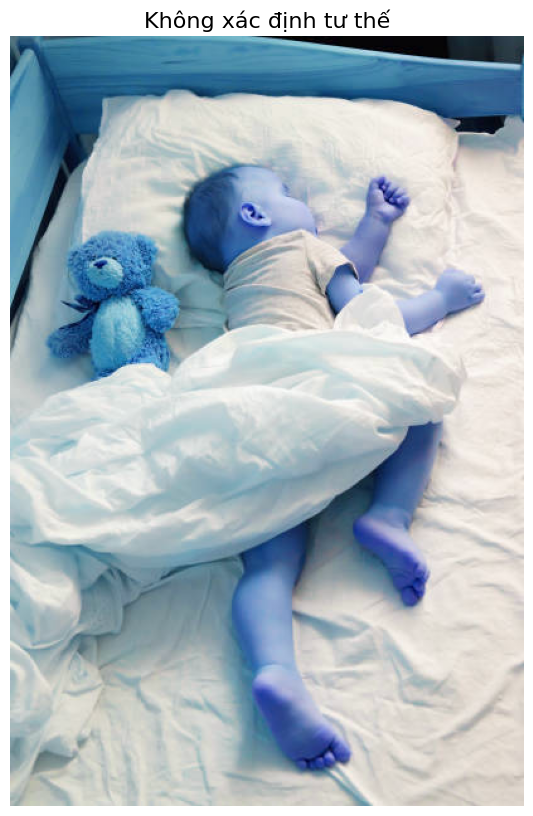

Ảnh ngẫu nhiên từ lớp nam_ngua: 21.jpg


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


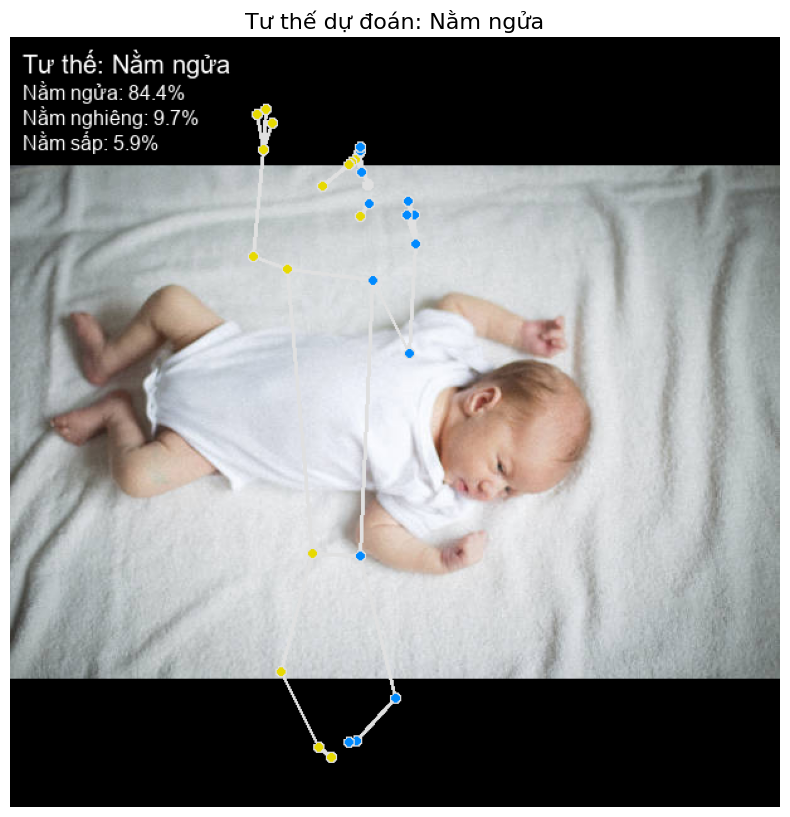

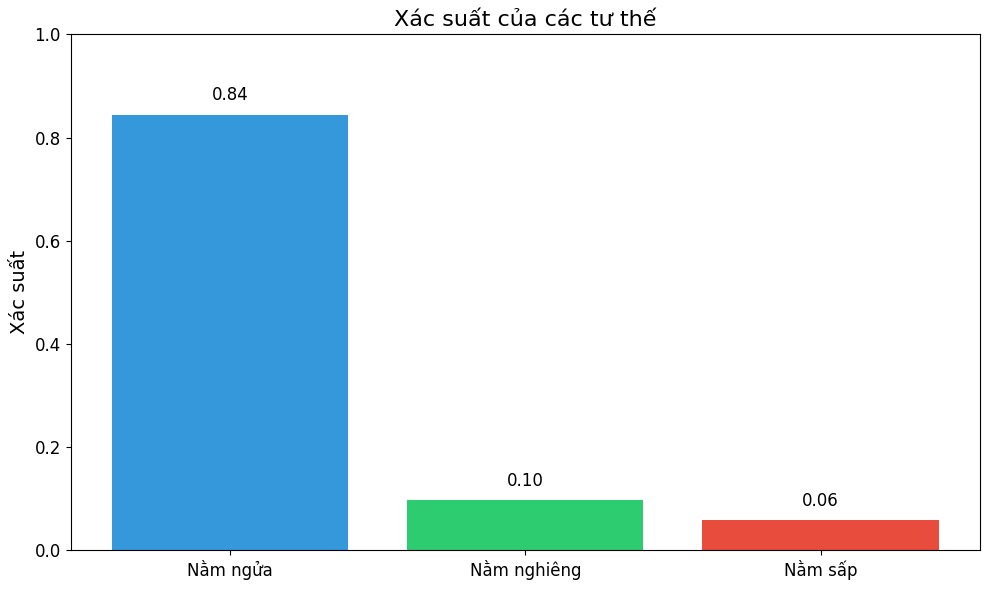

Ảnh ngẫu nhiên từ lớp nam_sap: 75.jpg


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


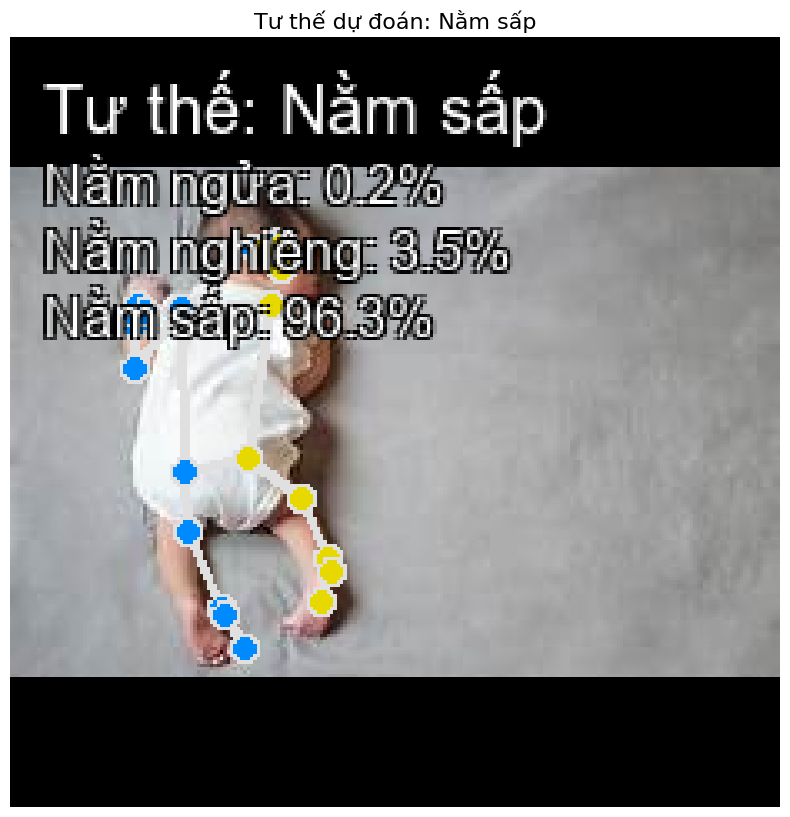

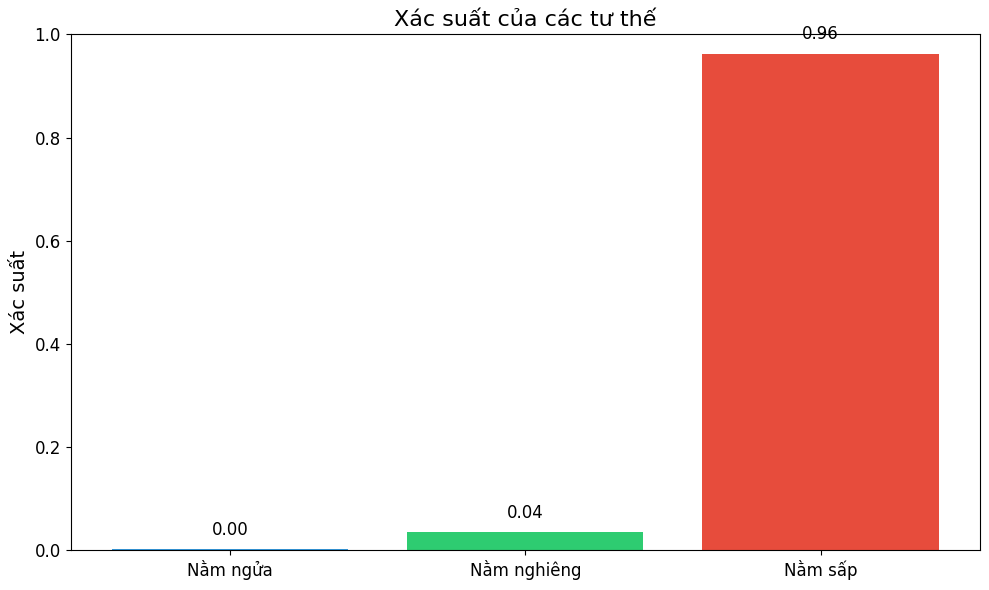

In [6]:
# Thử nghiệm với một ảnh từ tập test
# Import random để chọn ngẫu nhiên các ảnh test
import random

def test_random_image_from_class(class_name):
    """
    Test một ảnh ngẫu nhiên từ một lớp cụ thể trong tập test
    
    Args:
        class_name: Tên lớp (nam_nghieng, nam_ngua, nam_sap)
    """
    # Đường dẫn thư mục chứa ảnh test của lớp
    class_test_path = ROOT_PATH / 'data' / 'test' / class_name
    
    # Lấy danh sách các file ảnh trong thư mục
    image_files = list(class_test_path.glob('*.jpg')) + list(class_test_path.glob('*.png')) + list(class_test_path.glob('*.jpeg'))
    
    if not image_files:
        print(f"Không tìm thấy ảnh trong thư mục {class_test_path}")
        return
    
    # Chọn ngẫu nhiên một ảnh
    random_image_path = random.choice(image_files)
    print(f"Ảnh ngẫu nhiên từ lớp {class_name}: {random_image_path.name}")
    
    # Phân tích ảnh
    result_image, predicted_class, probabilities = pipeline.process_image(random_image_path)
    
    # Hiển thị kết quả
    display_result(result_image, predicted_class, probabilities)

# Test với mỗi lớp
for class_name in ['nam_nghieng', 'nam_ngua', 'nam_sap']:
    test_random_image_from_class(class_name)

## Test với ảnh tùy chỉnh

Phần này cho phép bạn chọn một ảnh bất kỳ để phân tích. Hãy thay đổi đường dẫn trong cell dưới đây để test với ảnh của bạn.

Đang phân tích ảnh: d:\GiaoPhan_Workspace\sem_6\pbl5\baby_posture_analysis\anh.jpg


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


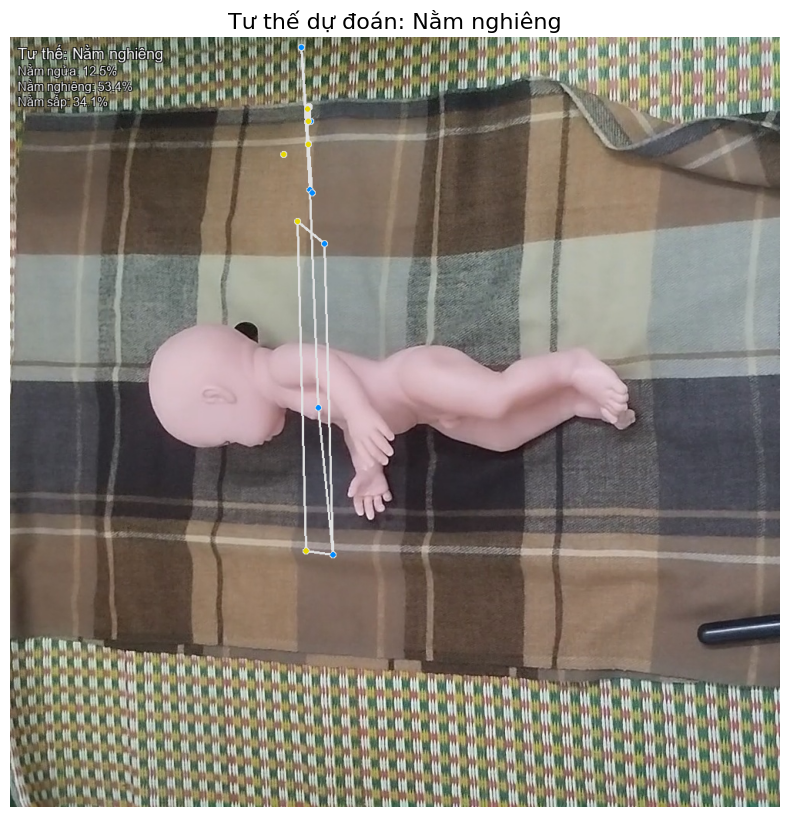

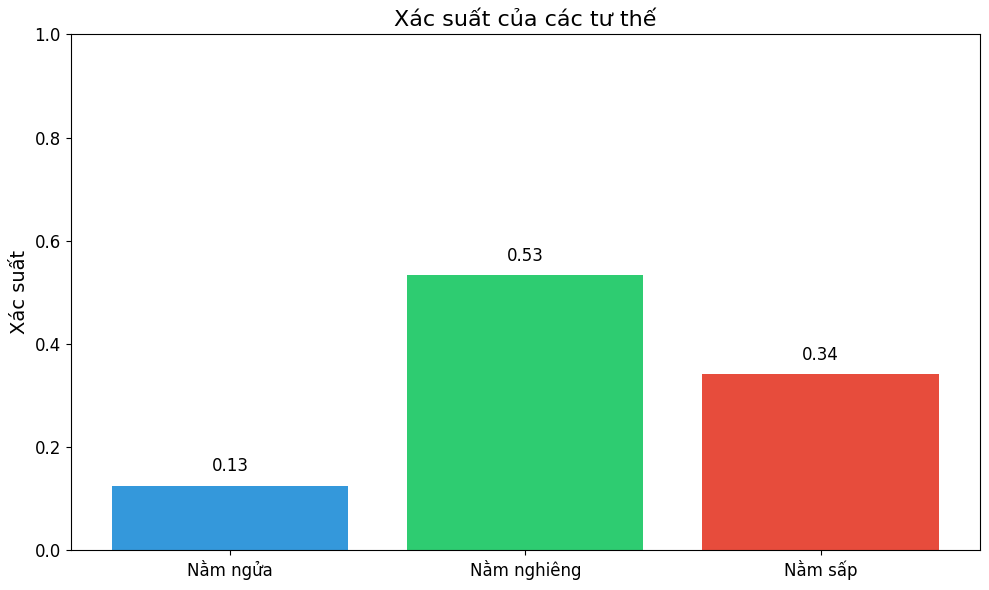

In [7]:
# Test với một ảnh tùy chỉnh (thay đổi đường dẫn này để test với ảnh của bạn)
custom_image_path = ROOT_PATH / 'anh.jpg'  # Thay đổi đường dẫn này

# Kiểm tra xem file có tồn tại không
if not custom_image_path.exists():
    print(f"Không tìm thấy file ảnh: {custom_image_path}")
else:
    print(f"Đang phân tích ảnh: {custom_image_path}")
    
    try:

        result_image, predicted_class, probabilities = pipeline.process_image(custom_image_path)
        
        # Kiểm tra xem kết quả có hợp lệ không
        if result_image is not None:
            # Hiển thị kết quả
            display_result(result_image, predicted_class, probabilities)
        else:
            print("Không thể phân tích ảnh. Kết quả trả về là None.")
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh: {str(e)}")
        print("Vui lòng thử lại với ảnh khác hoặc kiểm tra lại đường dẫn ảnh.")

In [8]:
# Đóng các resources
pipeline.pose.close()
cv2.destroyAllWindows()

## Kết luận

Notebook này đã xây dựng một pipeline hoàn chỉnh để phân tích tư thế em bé từ một ảnh đơn lẻ:

1. Đã tạo class `BabyPosturePipeline` với các chức năng:
   - Tiền xử lý ảnh
   - Trích xuất keypoints từ ảnh
   - Dự đoán tư thế sử dụng mô hình RandomForest đã huấn luyện
   - Hiển thị kết quả phân tích trên ảnh

2. Đã thử nghiệm pipeline với:
   - Các ảnh ngẫu nhiên từ tập test của từng lớp
   - Một ảnh tùy chỉnh do người dùng cung cấp

Pipeline này có thể được tích hợp vào một ứng dụng thực tế để phân tích tư thế em bé từ ảnh đơn lẻ.